## Loading packages

In [7]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [1]:
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


Defining where you want the results of the analysis to be

In [9]:
results_folder = './results/cell2locTutorial/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading Visium and reference scRNAseq data

In [10]:
# load visium with scanpy
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
# rename genes to ENSEMBL ID: so you can match scRNAseq with visium and can ignore the non-unique name warning in the previous cell
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

You can still plot gene expression by name using standard scanpy functions as follows:

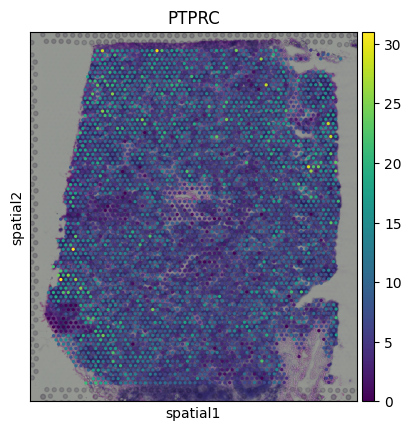

In [12]:
sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')

Filter out the mitochondria-encoded genes (gene names starting with prefix mt- or MT-), as they are not relevant for cell deconvolution

In [13]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

scRNAseq dataset downloading, importing into anndata and change variable names to ENSEMBL gene identifiers

In [2]:
# Read data
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [15]:
adata_ref.var['SYMBOL'] = adata_ref.var.index
adata_ref.var

GeneID-2   GeneName-2    feature_types  feature_types-0  \
NOC2L        ENSG00000188976        16551              nan  Gene Expression   
HES4         ENSG00000188290        11070              nan  Gene Expression   
ISG15        ENSG00000187608        12375              nan  Gene Expression   
TNFRSF18     ENSG00000186891        31000              nan  Gene Expression   
TNFRSF4      ENSG00000186827        30985              nan  Gene Expression   
...                      ...          ...              ...              ...   
IGL_VDJsum        IGL_VDJsum   IGL_VDJsum  Gene Expression  Gene Expression   
TCRA_VDJsum      TCRA_VDJsum  TCRA_VDJsum  Gene Expression  Gene Expression   
TCRB_VDJsum      TCRB_VDJsum  TCRB_VDJsum  Gene Expression  Gene Expression   
TCRD_VDJsum      TCRD_VDJsum  TCRD_VDJsum  Gene Expression  Gene Expression   
TCRG_VDJsum      TCRG_VDJsum  TCRG_VDJsum  Gene Expression  Gene Expression   

             feature_types-1       gene_ids-1 gene_ids-4861STDY7135913-0  \
NOC2L        Gene Expression  ENSG00000188976            ENSG00000188976   
HES4         Gene Expression  ENSG00000188290            ENSG00000188290   
ISG15        Gene Expression  ENSG00000187608            ENSG00000187608   
TNFRSF18     Gene Expression  ENSG00000186891            ENSG00000186891   
TNFRSF4      Gene Expression  ENSG00000186827            ENSG00000186827   
...                      ...              ...                        ...   
IGL_VDJsum   Gene Expression       IGL_VDJsum                 IGL_VDJsum   
TCRA_VDJsum  Gene Expression      TCRA_VDJsum                TCRA_VDJsum   
TCRB_VDJsum  Gene Expression      TCRB_VDJsum                TCRB_VDJsum   
TCRD_VDJsum  Gene Expression      TCRD_VDJsum                TCRD_VDJsum   
TCRG_VDJsum  Gene Expression      TCRG_VDJsum                TCRG_VDJsum   

            gene_ids-4861STDY7135914-0 gene_ids-4861STDY7208412-0  \
NOC2L                  ENSG00000188976            ENSG00000188976   
HES4                   ENSG00000188290            ENSG00000188290   
ISG15                  ENSG00000187608            ENSG00000187608   
TNFRSF18               ENSG00000186891            ENSG00000186891   
TNFRSF4                ENSG00000186827            ENSG00000186827   
...                                ...                        ...   
IGL_VDJsum                  IGL_VDJsum                 IGL_VDJsum   
TCRA_VDJsum                TCRA_VDJsum                TCRA_VDJsum   
TCRB_VDJsum                TCRB_VDJsum                TCRB_VDJsum   
TCRD_VDJsum                TCRD_VDJsum                TCRD_VDJsum   
TCRG_VDJsum                TCRG_VDJsum                TCRG_VDJsum   

            gene_ids-4861STDY7208413-0  ...  \
NOC2L                  ENSG00000188976  ...   
HES4                   ENSG00000188290  ...   
ISG15                  ENSG00000187608  ...   
TNFRSF18               ENSG00000186891  ...   
TNFRSF4                ENSG00000186827  ...   
...                                ...  ...   
IGL_VDJsum                  IGL_VDJsum  ...   
TCRA_VDJsum                TCRA_VDJsum  ...   
TCRB_VDJsum                TCRB_VDJsum  ...   
TCRD_VDJsum                TCRD_VDJsum  ...   
TCRG_VDJsum                TCRG_VDJsum  ...   

            mean_sample_effectSample_BCP004_Total  \
NOC2L                                    0.081671   
HES4                                     0.000077   
ISG15                                    0.269649   
TNFRSF18                                 0.001578   
TNFRSF4                                  0.016071   
...                                           ...   
IGL_VDJsum                               0.037641   
TCRA_VDJsum                              0.002853   
TCRB_VDJsum                              0.005596   
TCRD_VDJsum                              0.000684   
TCRG_VDJsum                              0.002343   

            mean_sample_effectSample_BCP005_Total  \
NOC2L                                    0.026212   
HES4                 

In [3]:
adata_ref.var['SYMBOL'] = adata_ref.var.index
# rename 'GeneID-2' as necessary for your data
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

In [5]:
adata_ref.obs

Age BCELL_CLONE  BCELL_CLONE_SIZE  \
AAACCTGGTAGAGCTG-1-4861STDY7135913  60-64y         nan               NaN   
AAACCTGGTGTCAATC-1-4861STDY7135913  60-64y         nan               NaN   
AAACCTGTCAGAGGTG-1-4861STDY7135913  60-64y         nan               NaN   
AAACGGGAGAGATGAG-1-4861STDY7135913  60-64y         nan               NaN   
AAACGGGAGTATGACA-1-4861STDY7135913  60-64y         nan               NaN   
...                                    ...         ...               ...   
TTTGTCAGTCATATGC-1-4861STDY7528600  20-25y         nan               NaN   
TTTGTCAGTCGACTGC-1-4861STDY7528600  20-25y         nan               NaN   
TTTGTCAGTCTACCTC-1-4861STDY7528600  20-25y         nan               NaN   
TTTGTCATCCTATGTT-1-4861STDY7528600  20-25y         nan               NaN   
TTTGTCATCTGAAAGA-1-4861STDY7528600  20-25y         nan               NaN   

                                   Donor               ID  IGH_MU_FREQ  \
AAACCTGGTAGAGCTG-1-4861STDY7135913  290b  4861STDY7135913          NaN   
AAACCTGGTGTCAATC-1-4861STDY7135913  290b  4861STDY7135913          NaN   
AAACCTGTCAGAGGTG-1-4861STDY7135913  290b  4861STDY7135913          NaN   
AAACGGGAGAGATGAG-1-4861STDY7135913  290b  4861STDY7135913          NaN   
AAACGGGAGTATGACA-1-4861STDY7135913  290b  4861STDY7135913          NaN   
...                                  ...              ...          ...   
TTTGTCAGTCATATGC-1-4861STDY7528600   A16  4861STDY7528600          NaN   
TTTGTCAGTCGACTGC-1-4861STDY7528600   A16  4861STDY7528600          NaN   
TTTGTCAGTCTACCTC-1-4861STDY7528600   A16  4861STDY7528600          NaN   
TTTGTCATCCTATGTT-1-4861STDY7528600   A16  4861STDY7528600          NaN   
TTTGTCATCTGAAAGA-1-4861STDY7528600   A16  4861STDY7528600          NaN   

                                   ISOTYPE           LibraryID Method  \
AAACCTGGTAGAGCTG-1-4861STDY7135913     nan       A3-mLN-0-F1-1   3GEX   
AAACCTGGTGTCAATC-1-4861STDY7135913     nan       A3-mLN-0-F1-1   3GEX   
AAACCTGTCAGAGGTG-1-4861STDY7135913     nan       A3-mLN-0-F1-1   3GEX   
AAACGGGAGAGATGAG-1-4861STDY7135913     nan       A3-mLN-0-F1-1   3GEX   
AAACGGGAGTATGACA-1-4861STDY7135913     nan       A3-mLN-0-F1-1   3GEX   
...                                    ...                 ...    ...   
TTTGTCAGTCATATGC-1-4861STDY7528600     nan  A16_tLN_TOT_5GEX_8   5GEX   
TTTGTCAGTCGACTGC-1-4861STDY7528600     nan  A16_tLN_TOT_5GEX_8   5GEX   
TTTGTCAGTCTACCTC-1-4861STDY7528600     nan  A16_tLN_TOT_5GEX_8   5GEX   
TTTGTCATCCTATGTT-1-4861STDY7528600     nan  A16_tLN_TOT_5GEX_8   5GEX   
TTTGTCATCTGAAAGA-1-4861STDY7528600     nan  A16_tLN_TOT_5GEX_8   5GEX   

                                      Population  ... leiden_3 leiden_4  \
AAACCTGGTAGAGCTG-1-4861STDY7135913  CD4+ T cells  ...       15       15   
AAACCTGGTGTCAATC-1-4861STDY7135913  CD4+ T cells  ...        7        7   
AAACCTGTCAGAGGTG-1-4861STDY7135913  CD4+ T cells  ...       16       16   
AAACGGGAGAGATGAG-1-4861STDY7135913  CD4+ T cells  ...       15       15   
AAACGGGAGTATGACA-1-4861STDY7135913  CD4+ T cells  ...        5        5   
...                                          ...  ...      ...      ...   
TTTGTCAGTCATATGC-1-4861STDY7528600         Total  ...       27       27   
TTTGTCAGTCGACTGC-1-4861STDY7528600         Total  ...        5        5   
TTTGTCAGTCTACCTC-1-4861STDY7528600         Total  ...        9        9   
TTTGTCATCCTATGTT-1-4861STDY7528600         Total  ...        1        1   
TTTGTCATCTGAAAGA-1-4861STDY7528600         Total  ...        9        9   

                                     CellType    CellType2         Subset  \
AAACCTGGTAGAGCTG-1-4861STDY7135913      TfH_3        TfH_3     T_CD4+_TfH   
AAACCTGGTGTCAATC-1-4861STDY7135913   T_CD4+_1     T_CD4+_1   T_CD4+_naive   
AAACCTGTCAGAGGTG-1-4861STDY7135913   T_CD8+_2     T_CD8+_2  T_CD8+_CD161+   
AAACGGGAGAGATGAG-1-4861STDY7135913      TfH_3        TfH_3     T_CD4+_TfH   
AAACGGGAGTATGACA-1-4861STDY7135913      TfH_1        TfH_1  T_CD4+_TfH_GC 

## Generate Reference Cell Type Matrix

### Preprocessing before estimating reference cell type signature

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

The default parameters `cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12` are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low `cell_count_cutoff=5`, however, `cell_percentage_cutoff2` and `nonz_mean_cutoff` can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

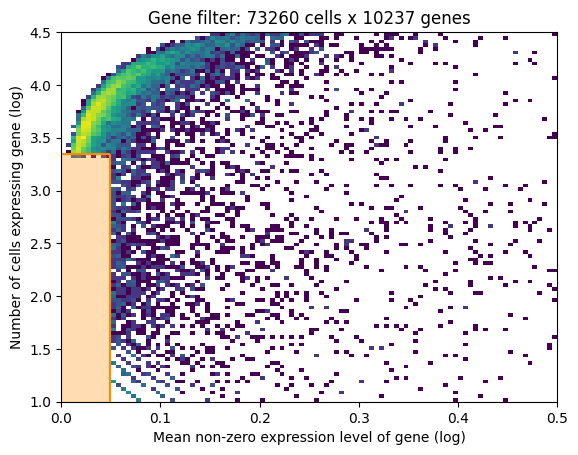

In [17]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

### Estimation of reference cell type signature (NB regression)

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [19]:
adata_ref.obs.Subset

AAACCTGGTAGAGCTG-1-4861STDY7135913       T_CD4+_TfH
AAACCTGGTGTCAATC-1-4861STDY7135913     T_CD4+_naive
AAACCTGTCAGAGGTG-1-4861STDY7135913    T_CD8+_CD161+
AAACGGGAGAGATGAG-1-4861STDY7135913       T_CD4+_TfH
AAACGGGAGTATGACA-1-4861STDY7135913    T_CD4+_TfH_GC
                                          ...      
TTTGTCAGTCATATGC-1-4861STDY7528600              ILC
TTTGTCAGTCGACTGC-1-4861STDY7528600    T_CD4+_TfH_GC
TTTGTCAGTCTACCTC-1-4861STDY7528600           T_Treg
TTTGTCATCCTATGTT-1-4861STDY7528600          B_naive
TTTGTCATCTGAAAGA-1-4861STDY7528600           T_Treg
Name: Subset, Length: 73260, dtype: category
Categories (34, object): ['B_Cycling', 'B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB', ..., 'T_TIM3+', 'T_TfR', 'T_Treg', 'VSMC']

In [17]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [18]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

### Training the model to estimate cell reference types.

Note that to achieve convergence on your data you may need to increase `max_epochs=250`, check by plotting ELBO loss history during training (remove first 20 epochs from the plot). If the plot is still decreasing by the end, increase `max_epochs` 

Also note that here we are using `batch_size=2500` which is much larger than scvi-tools default and perform training on all cells in the data (`train_size=1`) - both parameters are defaults.

In [21]:
mod.train(max_epochs=250, use_gpu=True)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_fl

Epoch 250/250: 100%|██████████| 250/250 [14:18<00:00,  3.48s/it, v_num=1, elbo_train=2.88e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [14:18<00:00,  3.43s/it, v_num=1, elbo_train=2.88e+8]


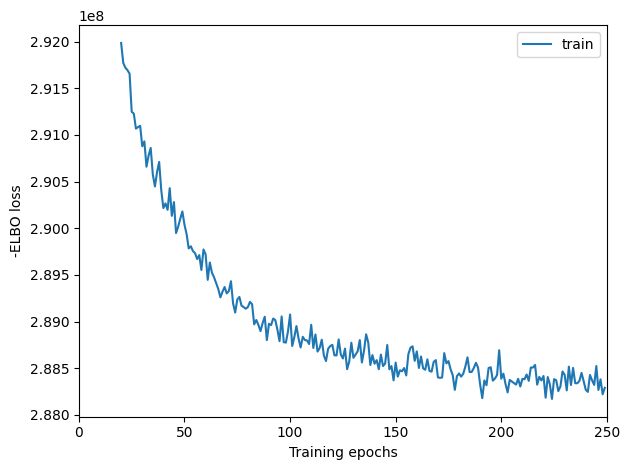

In [24]:
# ELBO plot of the history of training the model, with first 20 epochs removed
mod.plot_history(20)

In [25]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 125.33it/s]


'./results/cell2locTutorial//reference_signatures/sc.h5ad'

### Examine QC plots

Here we simply compute the quantiles based on the samples, as we need the posterior mean and steandard deviation to make the QC plot next cell. 

If you have a large dataset, you can compute the 5%, 50% and 95% quantiles of the posterior distribution directly rather than using 1000 samples from the distribution (or any other quantiles). This speeds up application on large datasets and requires less memory - however, posterior mean and standard deviation cannot be computed this way.

In [30]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=False,
    # choose quantiles
    #add_to_varm=["means", "stds", "q05", "q95"]
    #add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 125.78it/s]



* Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.
* The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.


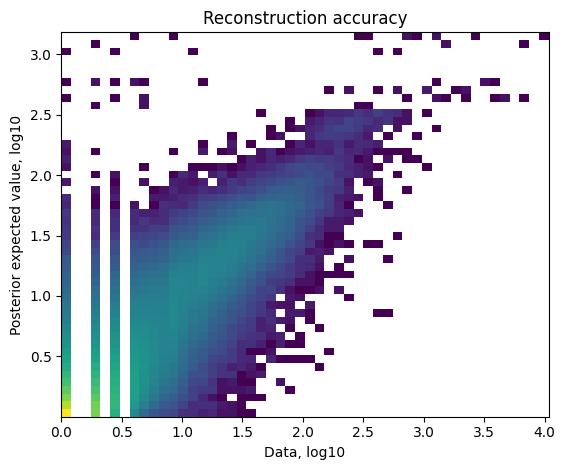

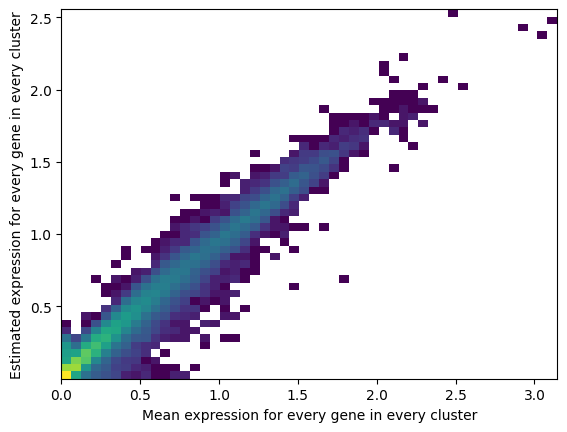

In [31]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:

In [32]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/cell2locTutorial//reference_signatures/model.pt already downloaded                         


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/273:   0%|          | 1/273 [00:00<00:21, 12.45it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/273:   0%|          | 1/273 [00:00<00:22, 12.02it/s, v_num=1]


Extracting reference cell types signatures as a pd.DataFrame.

All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:


In [33]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN
GeneID-2                                                            
ENSG00000188976   0.429518  0.244687  0.312215    0.348405  0.149274
ENSG00000188290   0.002218  0.000702  0.000709    0.055706  0.042168
ENSG00000187608   0.385764  0.215594  0.275723    0.505466  3.997697
ENSG00000186891   0.020342  0.000904  0.056284    0.069680  0.009591
ENSG00000186827   0.007764  0.000531  0.006601    0.033514  0.010740

## Cell2location: spatial mapping

Find shared genes and prepare anndata. Subset both anndata and reference signatures:

In [34]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

### Choose your hyperparameters

For detailed guidance on choosing your hyperparameters and their impact, [click here](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf). For a short summary, continue reading:


*Choosing hyperparameter `N_cells_per_location`*
* Estimate this hyperparameter based on the paired histology images, or if not avaiable you can use images from the same tissue of unrelated experiments. If both are not avaiable, you can give an estimate based on the spatial transcriptomics technique (i.e. Visium has on average 5 cells per spot) 
* If you do estimate based on an image, you pick 10-20 random locations and manually count the nuclei to compute average cell abundance. 
* Default is a single tissue-level estimate, but can also use per-location number of cells if there are large differences between different regions on your tissue slice. 

*Choosing hyperparameter `detection_alpha`*
* Determines the amount of regularization or per-location normalisation in preprocessing. You should choose based on the amount of technical variability in RNA detection sensitivity within your slide/batch. 
* high technical variability in RNA detection sensitivity is in your sample if your observed spatial distribution of total RNA count per location doesn't match the expected cell numbers based on histological examination.
* High technical effects? Choose `detection_alpha=20` (default, as this seems common for Visium experiments on human tissues)
* Low technical effects? Choose `detection_alpha=200`. High regularization improves consistency between total estimated cell abundance per location and the nuclei count quantified in `N_cells_per_location`
* Try both settings on your data, i.e. `detection_alpha=20` and `detection_alpha=200`





In [35]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()



Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4035  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10217 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Lymph_Node │          0          │
└─────────────────────┴─────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

### Train cell2location

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value

Epoch 30000/30000: 100%|██████████| 30000/30000 [44:23<00:00,  9.96it/s, v_num=1, elbo_train=4.55e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [44:23<00:00, 11.27it/s, v_num=1, elbo_train=4.55e+7]


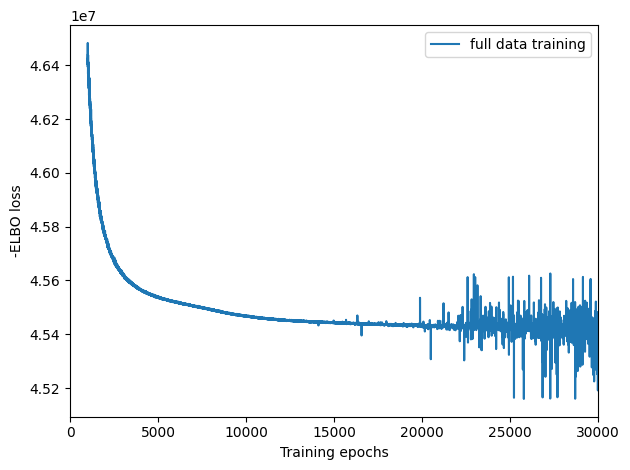

In [36]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

Exporting estimated posterior distributions of cell abundance and saving results:

In [37]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:14<00:00, 67.07it/s]


'./results/cell2locTutorial//cell2location_map/sp.h5ad'

The model and output h5ad can be loaded later like this:

In [38]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File ./results/cell2locTutorial//cell2location_map/model.pt already downloaded                            


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1/30000:   0%|          | 1/30000 [00:00<39:31, 12.65it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<41:01, 12.19it/s, v_num=1]


Assessing mapping quality. Examine reconstruction accuracy to assess if there are any issues with mapping. The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.

Sampling global variables, sample: 100%|██████████| 999/999 [00:10<00:00, 99.65it/s] 


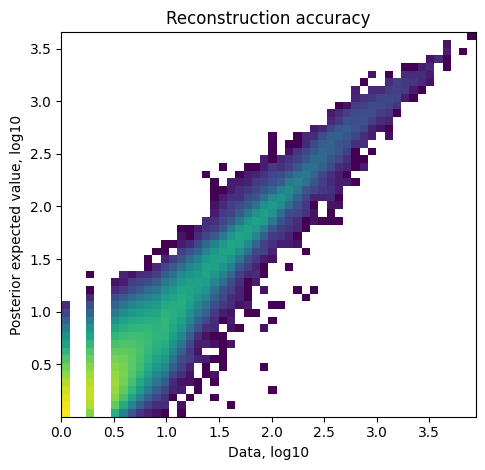

In [42]:
mod.export_posterior(adata_vis)
mod.plot_QC()

When intergrating multiple spatial batches and when working with datasets that have substantial variation of detected RNA within slides (that cannot be explained by high cellular density in the histology), it is important to assess whether cell2location normalised those effects. You expect to see similar total cell abundance across batches but distinct RNA detection sensitivity (both estimated by cell2location). You expect total cell abundance to mirror high cellular density in the histology.

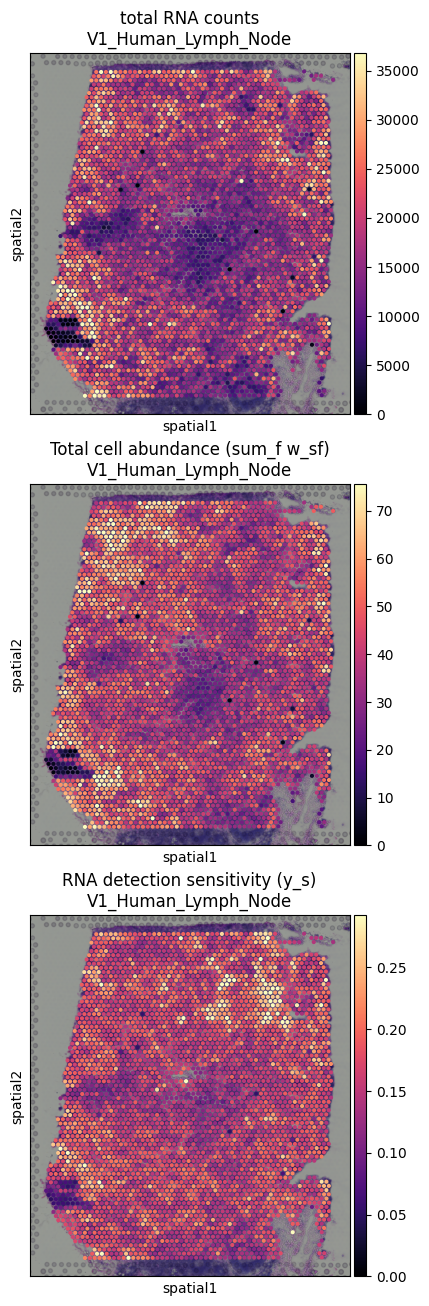

In [43]:
fig = mod.plot_spatial_QC_across_batches()

## Visualising cell abundance in spatial coordinates

Note: Cell2location recommends using 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka ‘at least this amount is present’).

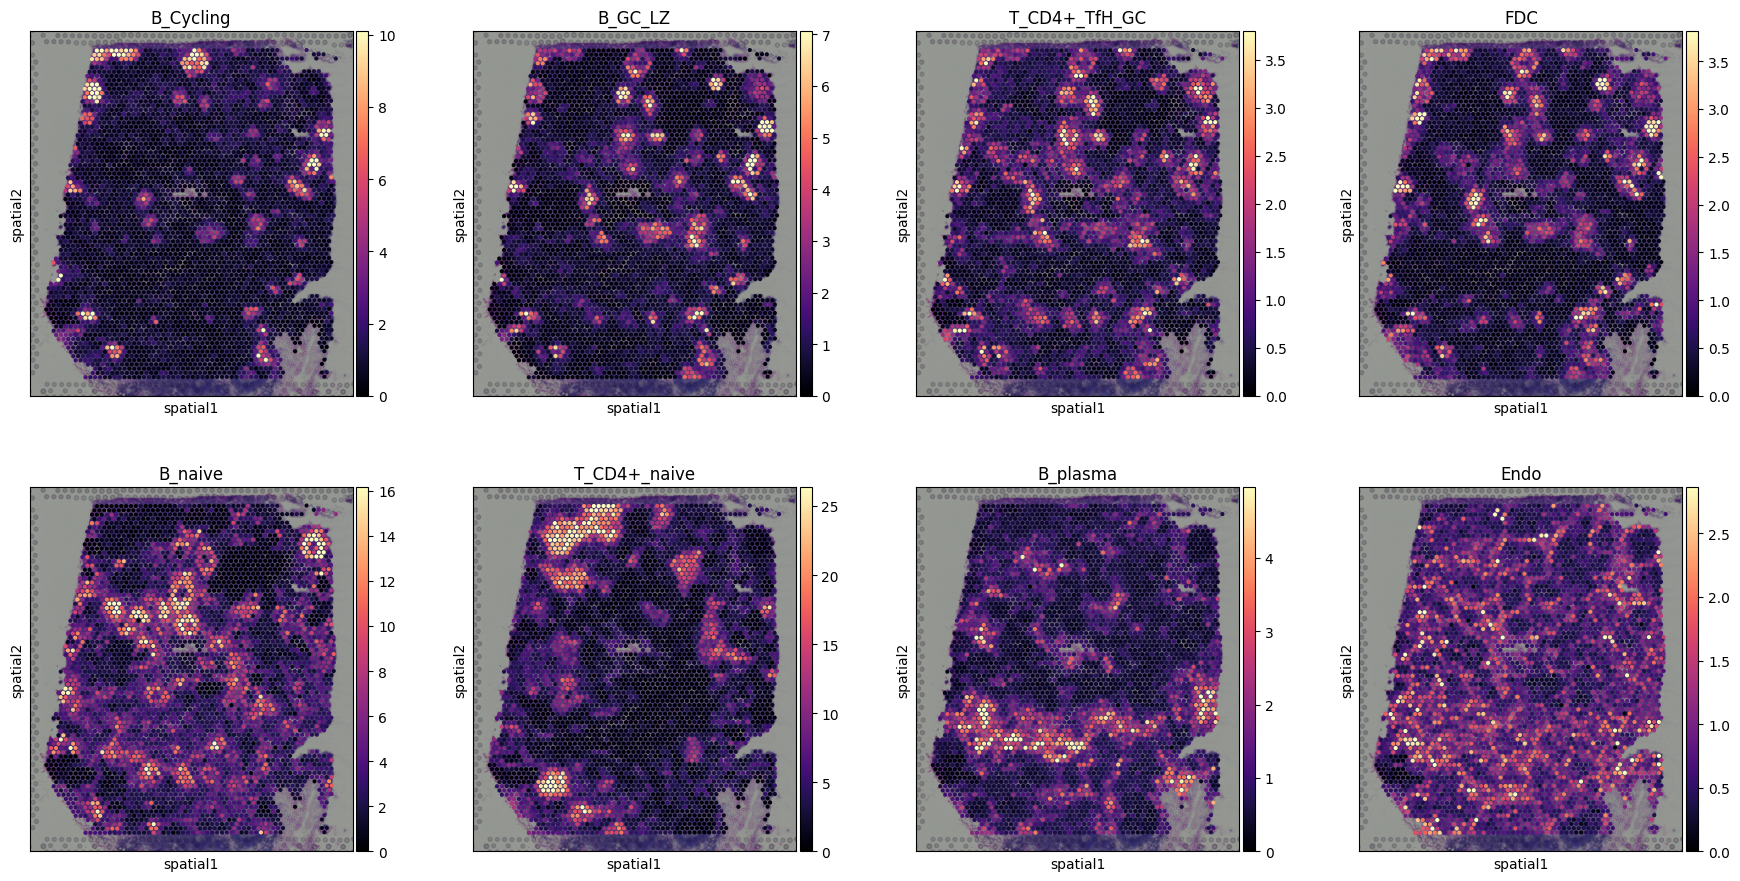

In [44]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

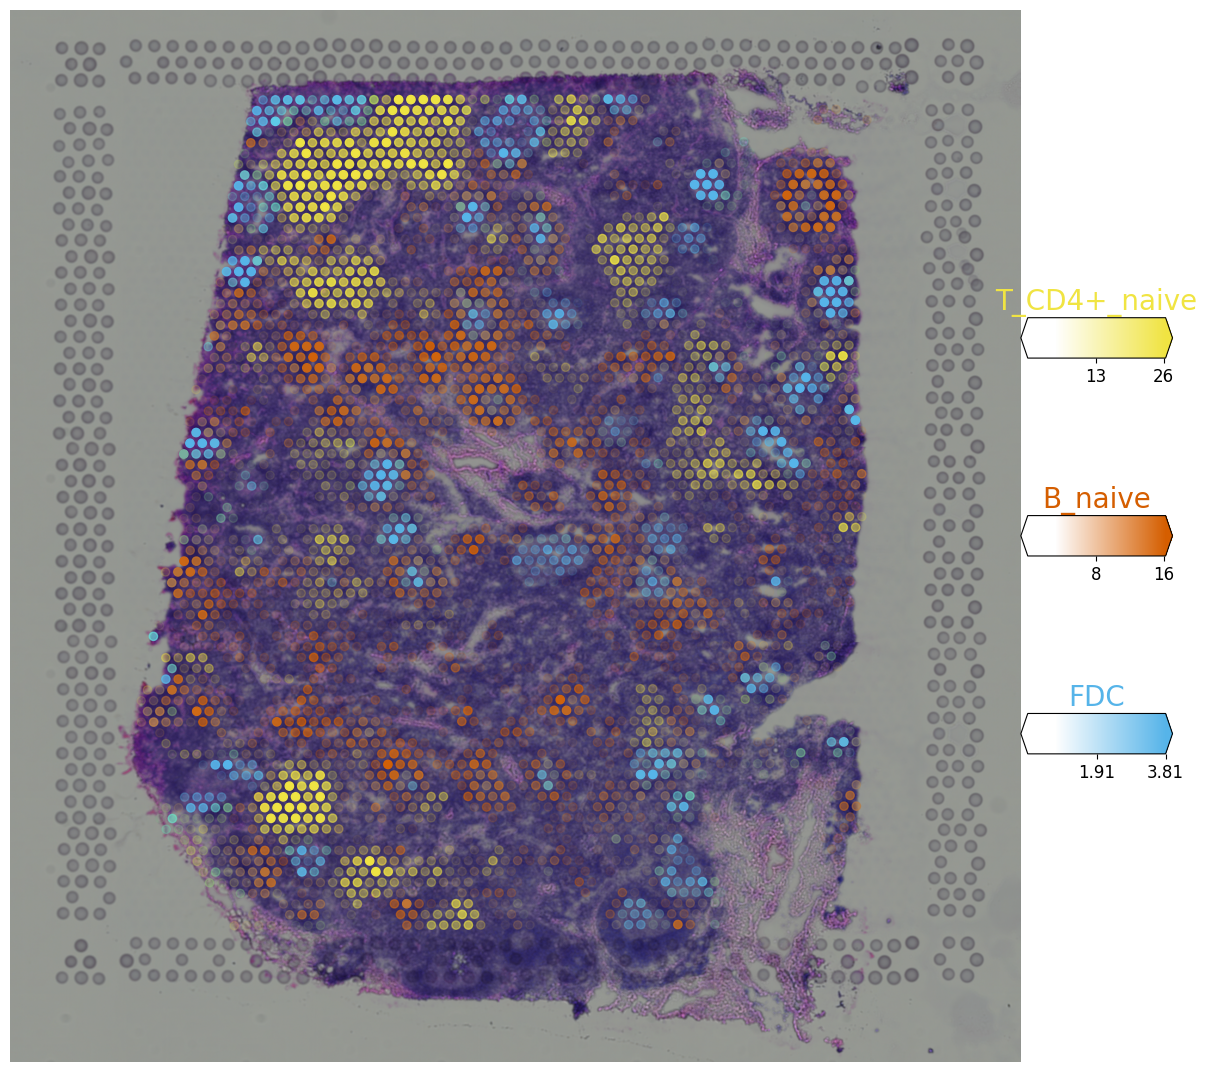

In [45]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['T_CD4+_naive', 'B_naive', 'FDC']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

## Downstream analysis

### Identifying discrete tissue regions by Leiden clustering

We identify tissue regions that differ in their cell composition by clustering locations using cell abundance estimated by cell2location.

We find tissue regions by clustering Visium spots using estimated cell abundance each cell type. We constuct a K-nearest neigbour (KNN) graph representing similarity of locations in estimated cell abundance and then apply Leiden clustering. The number of KNN neighbours should be adapted to size of dataset and the size of anatomically defined regions (e.i. hippocampus regions are rather small compared to size of the brain so could be masked by large `n_neighbors`). This can be done for a range KNN neighbours and Leiden clustering resolutions until a clustering matching the anatomical structure of the tissue is obtained.

The clustering is done jointly across all Visium sections / batches, hence the region identities are directly comparable. When there are strong technical effects between multiple batches (not the case here) `sc.external.pp.bbknn` can be in principle used to account for those effects during the KNN construction.

The resulting clusters are saved in `adata_vis.obs['region_cluster']`..

In [50]:
import leidenalg

In [51]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")



We can use the location composition similarity graph to build a joint integrated UMAP representation of all section/Visium batches

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


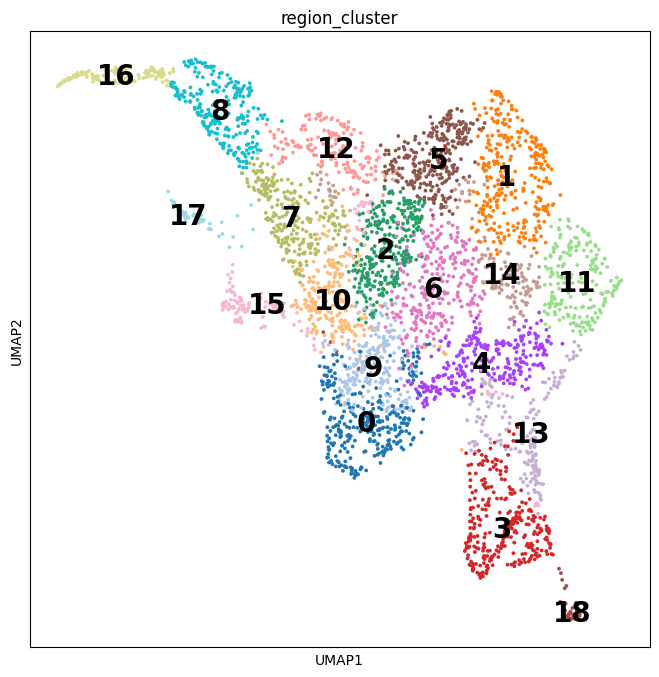

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


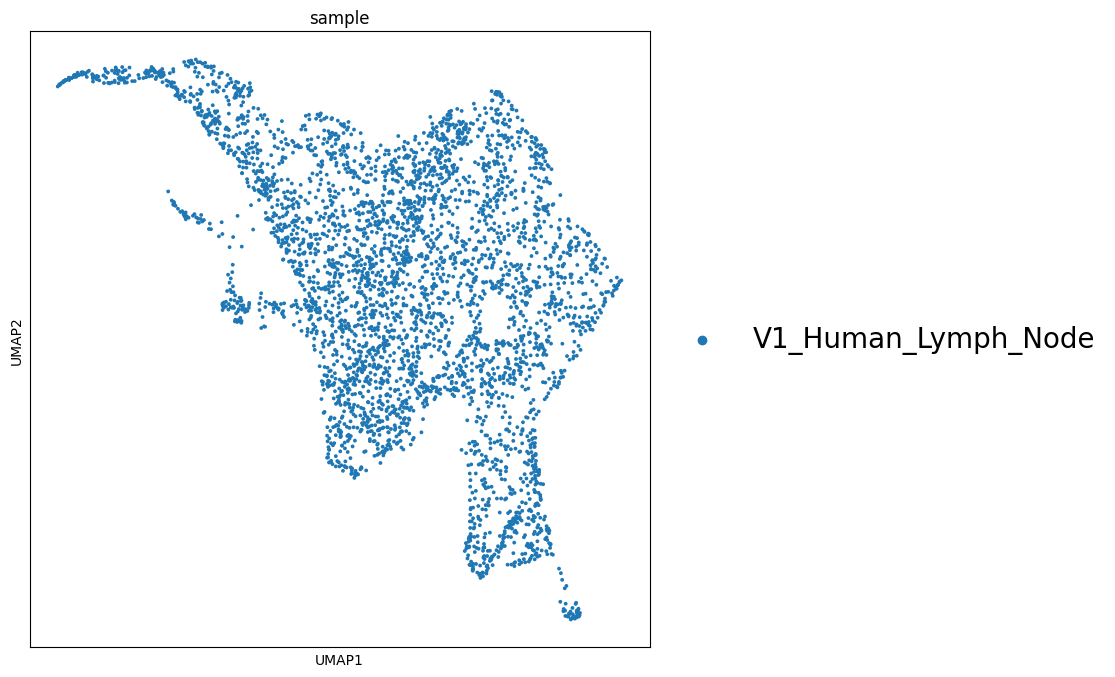

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


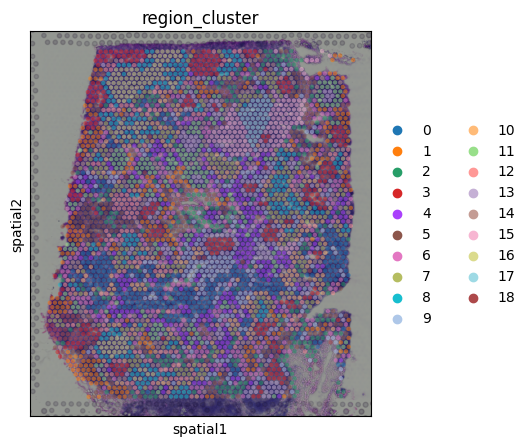

In [52]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)



### Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

Use non-negative matrix factorization (NMF) to capture which cell types co-localise. This decomposition naturally accounts for the fact that multiple cell types and microenvironments can co-exist at the same Visium locations, while sharing information across tissue areas (e.g. individual germinal centres)

**Tip**
* In practice, it is beetter to train NMF for a range of factors *R = 5,...,30* and select *R* as a balance between capturing fine-grained and splitting known well-established tissue zones
* If want to find a few most distinct cellular compartments, use a small number of factors. If you want to find very strong co-location signal and assume that most cell types don't co-locate, use a lot of factors (> 30 - used here)


The pipeline below automatically trains the NMF model with varying number of factors

In [53]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factors


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factors


For every factor number, the model produces the following list of folder outputs:

* `cell_type_fractions_heatmap/`: a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns)
* `cell_type_fractions_mean/`: the data used for dot plot
* `factor_markers/`: tables listing top 10 cell types most speficic to each NMF factor
* `models/`: saved NMF models
* `predictive_accuracy/`: 2D histogram plot showing how well NMF explains cell2location output
* `spatial/`: NMF weights across locatinos in spatial coordinates
* `location_factors_mean/`: the data used for the plot in spatial coordiantes
* `stability_plots/`: stability of NMF weights between training restarts

Key output that you want to examine are the files in `cell_type_fractions_heatmap/` which show a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns) which correspond to cellular compartments. Shown are relative weights, normalized across components for every cell type.

The NMF model output such as factor loadings are stored in `adata.uns[f"mod_coloc_n_fact{n_fact}"]` in a similar output format as main cell2location results in `adata.uns['mod']`.


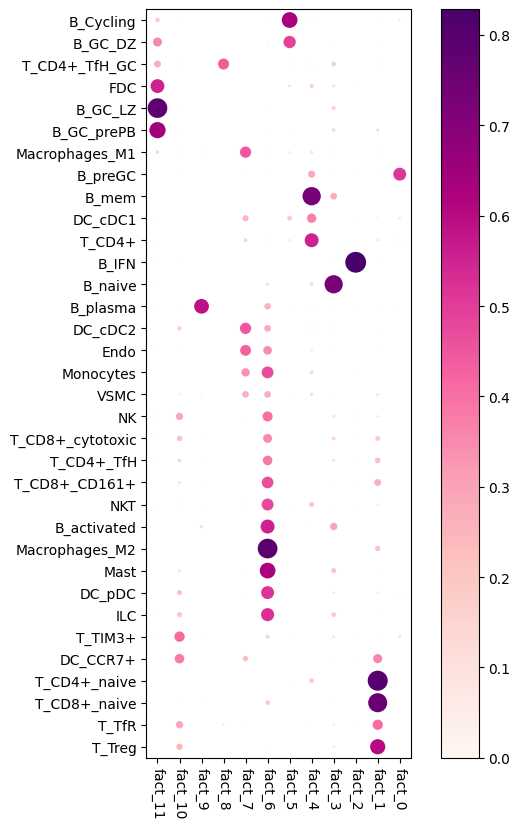

In [54]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
